In [100]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
results = pd.read_csv('data/results.csv')
races = pd.read_csv('data/races.csv')

df = pd.merge(results, races, on = ['raceId'])
df = df.drop(['fp1_date', 'fp1_time', 'fp2_date', 'fp2_time',
'fp3_date', 'fp3_time', 'url', 'quali_date', 'quali_time',
'sprint_date', 'sprint_time', 'date', 'time_y', 'name',
'fastestLapTime', 'fastestLapSpeed', 'statusId', 'time_x', 'milliseconds'], axis = 1)
df = df[df['year'] != 2022]
test = df.groupby(['driverId', 'year'])['points'].apply(sum)
test = test.reset_index()
df.head(10)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,fastestLap,rank,year,round,circuitId
0,1,18,1,1,22,1,1,1,1,10.0,58,39,2,2008,1,1
1,2,18,2,2,3,5,2,2,2,8.0,58,41,3,2008,1,1
2,3,18,3,3,7,7,3,3,3,6.0,58,41,5,2008,1,1
3,4,18,4,4,5,11,4,4,4,5.0,58,58,7,2008,1,1
4,5,18,5,1,23,3,5,5,5,4.0,58,43,1,2008,1,1
5,6,18,6,3,8,13,6,6,6,3.0,57,50,14,2008,1,1
6,7,18,7,5,14,17,7,7,7,2.0,55,22,12,2008,1,1
7,8,18,8,6,1,15,8,8,8,1.0,53,20,4,2008,1,1
8,9,18,9,2,4,2,\N,R,9,0.0,47,15,9,2008,1,1
9,10,18,10,7,12,18,\N,R,10,0.0,43,23,13,2008,1,1


In [101]:
df.isnull().sum()

resultId         0
raceId           0
driverId         0
constructorId    0
number           0
grid             0
position         0
positionText     0
positionOrder    0
points           0
laps             0
fastestLap       0
rank             0
year             0
round            0
circuitId        0
dtype: int64

In [53]:
# https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy

def G(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

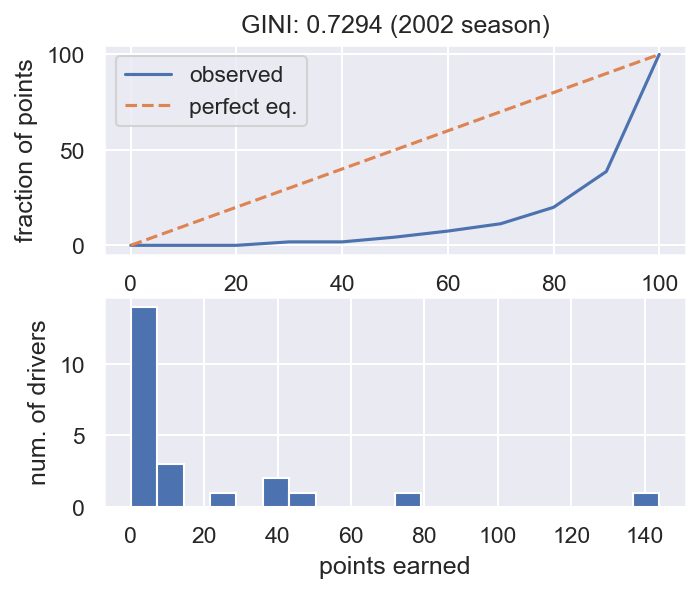

In [73]:
season_2015 = df.groupby(['year', 'driverId'])['points'].apply(list)
season_2015 = season_2015.reset_index()
season_2015 = season_2015[season_2015['year'] == 2002]
season_2015['total_points'] = list(map(lambda x: sum(x), season_2015['points']))

# v = np.random.rand(500)
v = season_2015['total_points'].values
bins, result, gini_val = G(v)


plt.figure(dpi = 150, figsize = (5, 4));
plt.subplot(2, 1, 1);
plt.plot(bins, result, label="observed")
plt.plot(bins, bins, '--', label="perfect eq.")
plt.ylabel("fraction of points")
plt.xlabel('fraction of driver population')
plt.title("GINI: %.4f (2002 season)" %(gini_val))
plt.legend();
plt.subplot(2, 1, 2);
plt.xlabel("points earned")
plt.ylabel('num. of drivers')
plt.hist(v, bins=20);

Text(0.5, 1.0, 'Gini Coefficient of Point Distribution by Season')

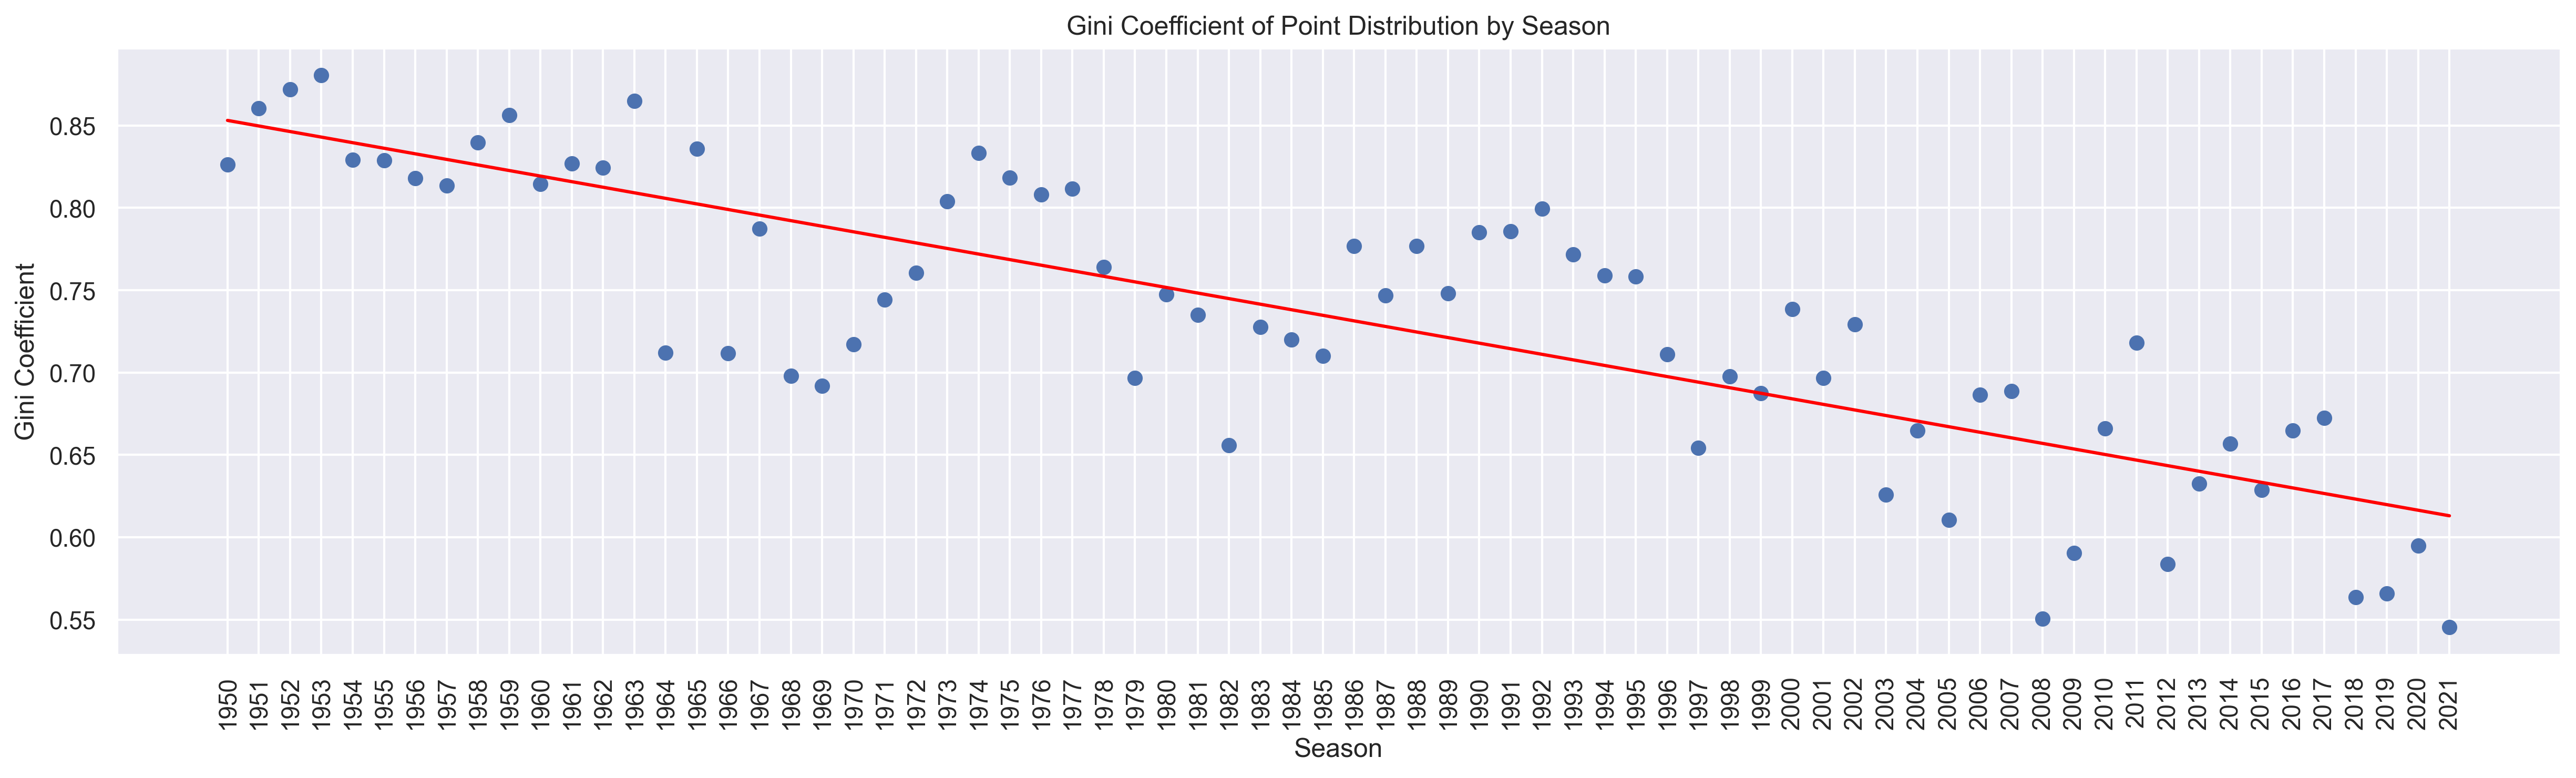

In [55]:
point_totals = df.groupby(['year', 'driverId'])['points'].apply(sum).reset_index()
years = []
ginis = []
for y in point_totals['year'].unique():
    cur = point_totals[point_totals['year'] == y]
    v = cur['points'].values
    bins, result, gini_val = G(v)
    years.append(y)
    ginis.append(gini_val)

asdf = list(zip(years, ginis))
gc = pd.DataFrame(asdf, columns = ['year', 'gini coefficient'])

plt.figure(figsize = (20, 5), dpi = 300);

# https://www.statology.org/matplotlib-trendline/
trend = np.poly1d(np.polyfit(years, ginis, 1))
plt.plot(years, trend(years), color = 'red')

# plt.plot(years, ginis);
plt.scatter(x = years, y = ginis)
plt.xticks(years, rotation = 90);
plt.ylabel('Gini Coefficient')
plt.xlabel('Season')
plt.title('Gini Coefficient of Point Distribution by Season')


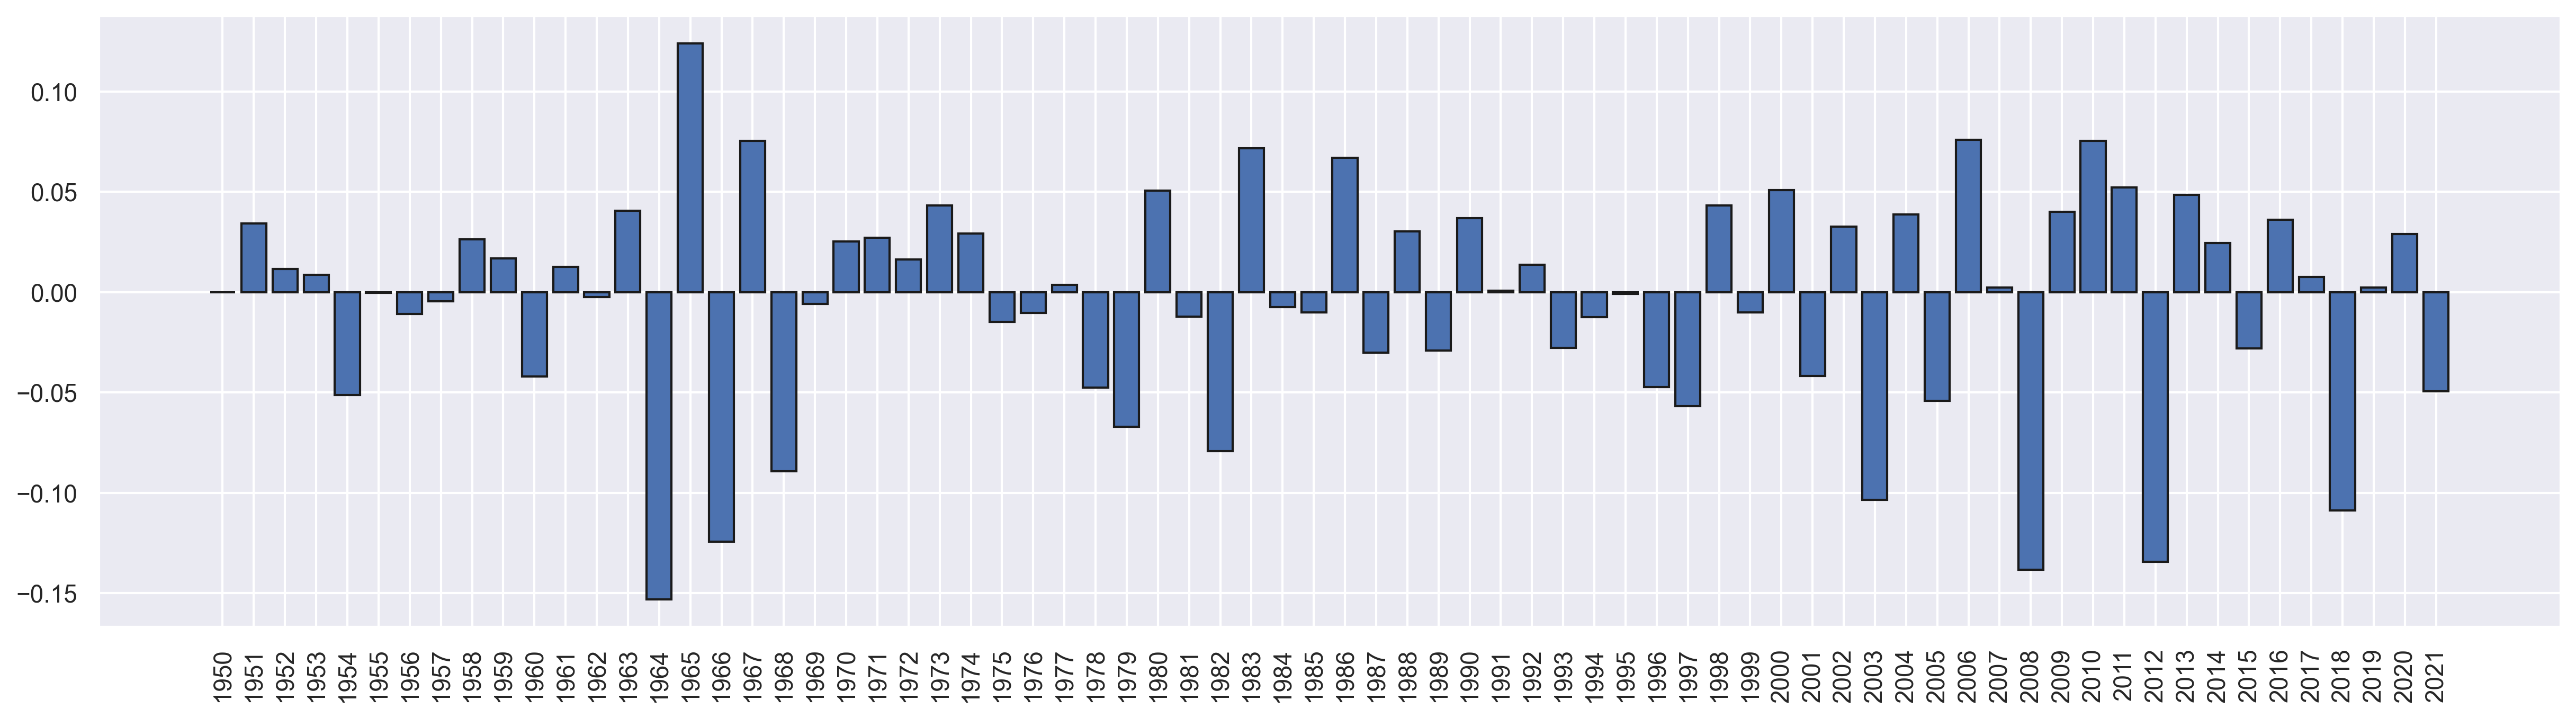

In [60]:

deltas = []
deltas.append(0)
for i in range(1, len(ginis)):
    deltas.append(ginis[i] - ginis[i-1])

colors = []
colors.append('lightgreen')
for i in range(len(deltas)):
    if deltas[i] > 0:
        colors.append('red')
    else:
        colors.append('lightgreen')

direction = []
direction.append(True)
for d in deltas:
    direction.append(d > 0)

plt.figure(figsize = (20, 5), dpi = 300);
plt.bar(data = deltas, x = years, height = deltas, edgecolor = 'k');
plt.xticks(years, rotation = 90);

,0,1
0,1.000000,0.136206
1,0.136206,1.000000


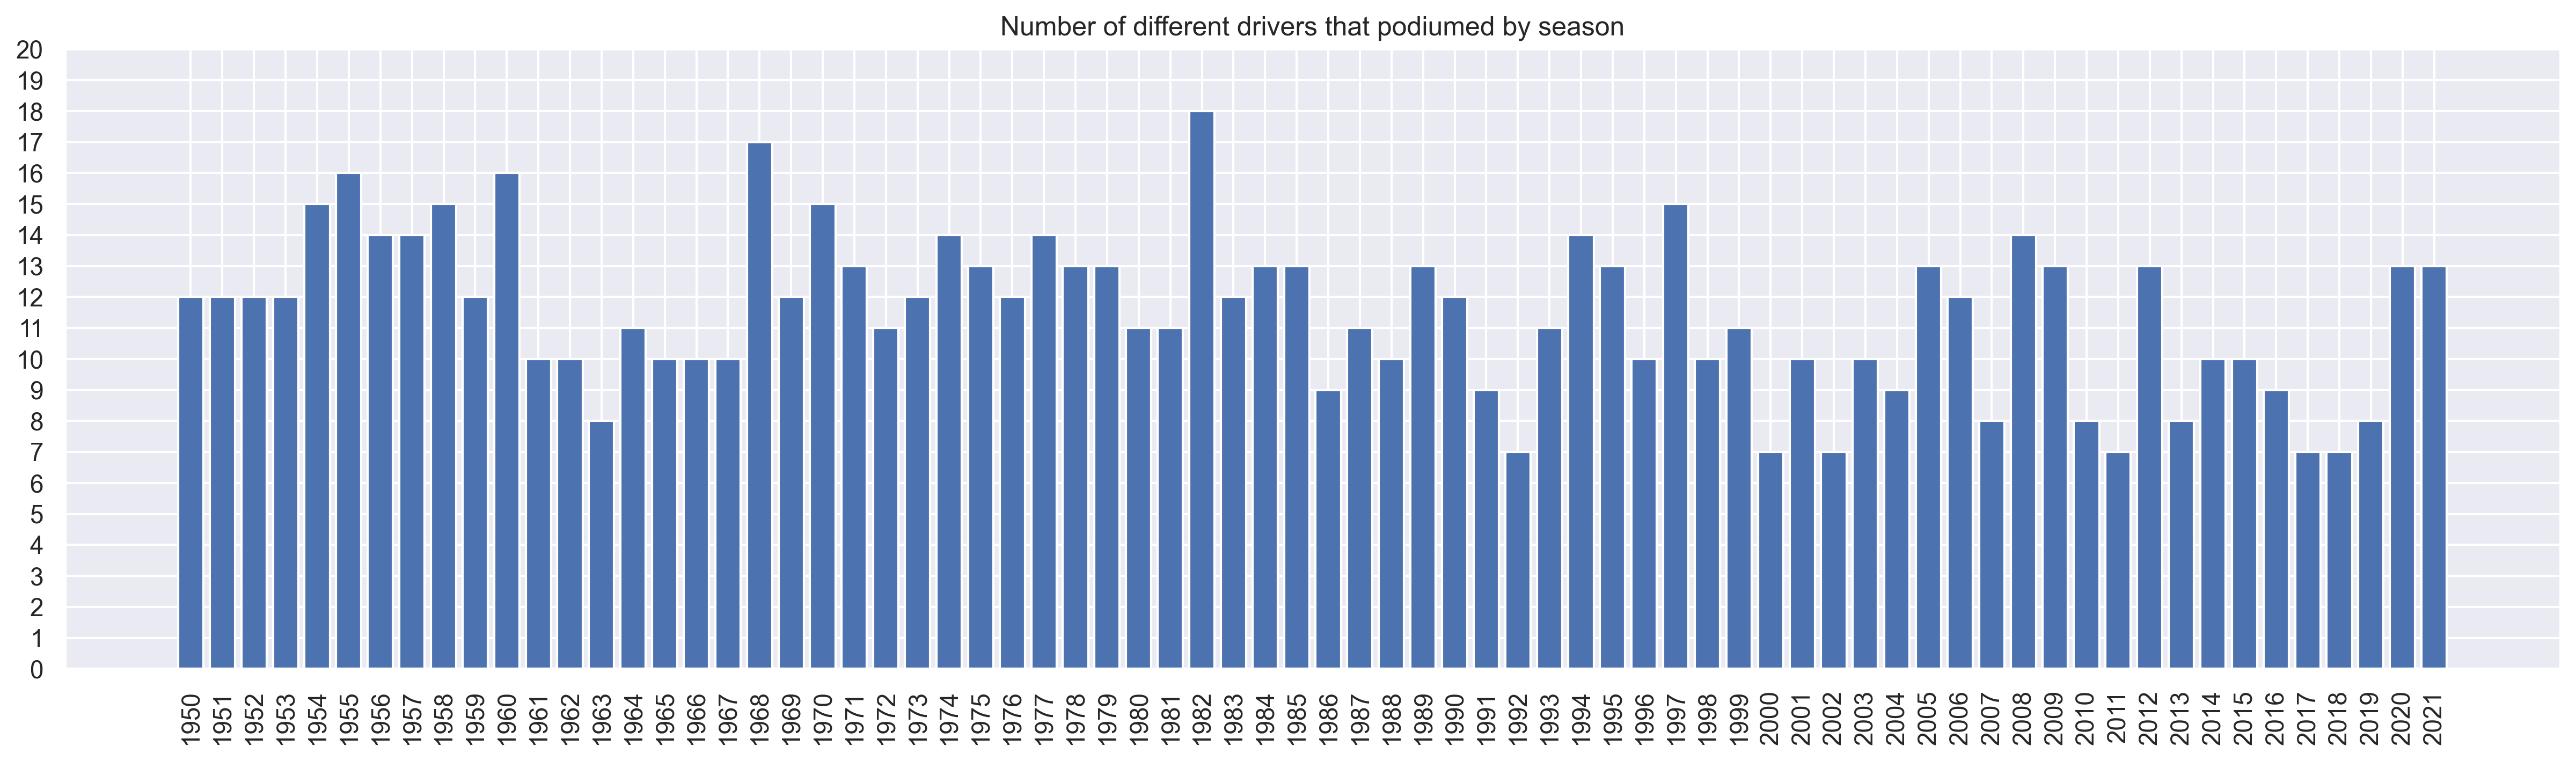

In [86]:
unique_podiums = pd.merge(races, results, on = ['raceId'])
unique_podiums = unique_podiums.groupby(['year', 'position'])['driverId'].apply(list)
unique_podiums = unique_podiums.reset_index()
unique_podiums = unique_podiums[unique_podiums['position'] != '\\N']
unique_podiums = unique_podiums[unique_podiums['year'] != 2022]
unique_podiums['position'] = unique_podiums['position'].astype(int)
unique_podiums = unique_podiums[unique_podiums['position'] <= 3]
unique_podiums = unique_podiums.groupby(['year'])['driverId'].apply(list)
unique_podiums = unique_podiums.reset_index()
unique_podiums['driverId'] = list(map(lambda x: x[0]+x[1]+x[2], unique_podiums['driverId']))
unique_podiums['diff_podiums'] = list(map(lambda x: len(np.unique(x)), unique_podiums['driverId']))


plt.figure(dpi = 300, figsize = (20, 5))
plt.bar(x = years, height = unique_podiums['diff_podiums'])
plt.xticks(years, rotation = 90);
plt.yticks(np.arange(0, 21, 1))
plt.title('Number of different drivers that podiumed by season')

check_corr = pd.DataFrame(list(zip(unique_podiums['diff_podiums'], ginis)))
check_corr.corr()

In [ ]:
lap_times = pd.read_csv('data/lap_times.csv')
df2 = pd.merge(lap_times, races, on = ['raceId'])

test2 = df2.groupby(['raceId', 'driverId', 'year'])['milliseconds'].apply(list)
test2 = test2.reset_index()
test2['num_laps'] = test2['milliseconds'].apply(len)
# Because n = 30 is a big deal and stuff
test2 = test2[test2['num_laps'] >= 30]
test2['std_dev'] = list(map(lambda x: np.asarray(x).std()/1000, test2['milliseconds']))
test2 = test2[test2['std_dev'] < 22]

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score

test = df[['raceId', 'driverId', 'year', 'grid', 'position']]
test = test[test['position'] != '\\N']
test['position'] = test['position'].astype(int)
test.corr()

test = pd.merge(test, test2, on = ['raceId', 'driverId'])

X_train, X_test, y_train, y_test = train_test_split(test[['grid', 'std_dev']], test['position'].values, train_size = 0.8, random_state = 0)
cnb = CategoricalNB()
cnb.fit(X_train, y_train)
y_pred = cnb.predict(X_test)
print("Accuracy")
print(accuracy_score(y_pred, y_test))


Accuracy
0.17201998572448252
